<a href="https://colab.research.google.com/github/hannahzafar/UMDAOSC650/blob/main/Copy_of_firstrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

An example using ONI (Oceanic Nino Index).

Let's predict a future ONI value using four previous values.

First, we will tackle a Many (4 input time steps) to One (1 future time step) framework.

Second, we will tackle a Many (4 input time steps) to Many (Y future time steps) framework. The Many-to-Many framework does not need to be Tx==Ty (but can be).

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector
import keras
from keras.src.preprocessing.sequence import TimeseriesGenerator
# from google.colab import drive
# drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [2]:
# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

In [3]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [4]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
884,ASO,2023,28.32,1.56
885,SON,2023,28.49,1.78
886,OND,2023,28.60,1.92
887,NDJ,2023,28.57,1.95
888,DJF,2024,28.44,1.80


In [5]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [ ]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,889.000000,889.000000,889.000000
mean,1986.542182,26.900157,0.011102
std,21.397005,0.943204,0.838484
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2005.000000,27.540000,0.530000
max,2024.000000,29.260000,2.640000


<Axes: xlabel='YR'>

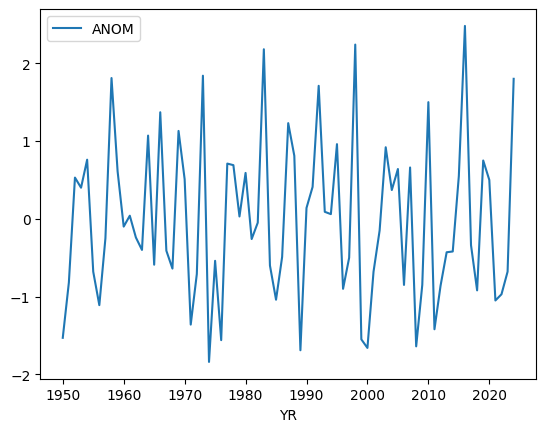

In [6]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [7]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [8]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [9]:
# checking shapes -- make sure (samples, features)
print(trainds.shape, testsds.shape)

(732, 1) (157, 1)


In [10]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [11]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

# Many-to-One LSTM

In [13]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape (e.g., here we make it 1)
target = data # Here prediction and input are the same?

# the length of the input feature
n_input=4 # you can change this! doesn't HAVE to be 4 months input
n_features=data.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16, # you can try different batch sizes
                               shuffle=True)

In [14]:
# check shapes
print(data.shape, target.shape, n_features)

(732, 1) (732, 1) 1


In [15]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.4785553 ]
 [0.503386  ]
 [0.55530474]
 [0.60496614]] [0.63656885]
(16, 4, 1) (16, 1)


In [30]:
# many-to-one example
# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time) and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))

# don't return sequence; just the last output of the input sequence
# regressor.add(LSTM(units=50, return_sequences=False))
#FALSE: many to one, #TRUE: many to many
#increasing number of units improves performance?? Vague in the documentation
regressor.add(LSTM(units=1, return_sequences=False))

# one neuron for output prediction
regressor.add(Dense(1))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (16, 1)                   12        
                                                                 
 dense_3 (Dense)             (16, 1)                   2         
                                                                 
 activation_3 (Activation)   (16, 1)                   0         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# train the lstm!
# regressor.fit(data_gen, epochs=20)
regressor.fit(data_gen, epochs=50)


Epoch 1/50
46/46 [==============================] - 3s 3ms/step - loss: 0.3977 - mse: 0.3977 - mae: 0.5825
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.2656 - mse: 0.2656 - mae: 0.4625
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1890 - mse: 0.1890 - mae: 0.3797
Epoch 4/50
46/46 [==============================] - 0s 3ms/step - loss: 0.1351 - mse: 0.1351 - mae: 0.3116
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1040 - mse: 0.1040 - mae: 0.2626
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0742 - mse: 0.0742 - mae: 0.2154
Epoch 7/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0566 - mse: 0.0566 - mae: 0.1879
Epoch 8/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0503 - mse: 0.0503 - mae: 0.1780
Epoch 9/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0430 - mse: 0.0430 - mae: 0.1637
Epoch 10/50
46/46 [==================

In [25]:
# here goes our testing data that was already scaled
testdata = testsds_scaled

testtarget = testdata

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [26]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578]
(153, 4, 1) (153, 1)


In [27]:
# predict using test data
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 1s 582ms/step


In [22]:
# quick check that we have a match of shapes
print(oni_predictions.shape, y.shape)

(153, 1) (153, 1)


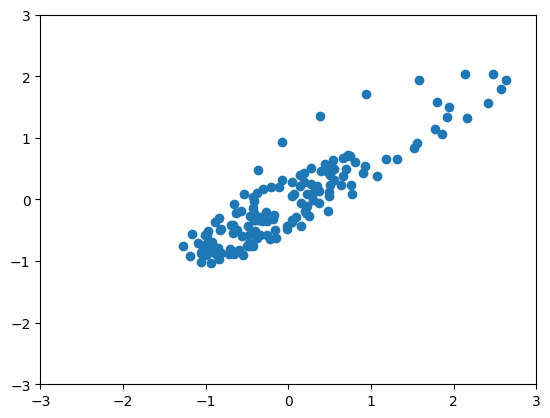

In [29]:
# how did we do!?
plt.scatter(
    sc.inverse_transform(y).reshape(-1),
    sc.inverse_transform(oni_predictions).reshape(-1)
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# Many-to-Many LSTM

In [32]:
# redoing data preprocessing steps here more quickly

# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [34]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape #previously for many to one, we had data and target as the same, but now they are different
target = np.concatenate((np.roll(data, 0, axis=0),
                         np.roll(data, -1, axis=0),
                         np.roll(data, -2, axis=0),
                         #np.roll(data, -3, axis=0)
                        ), axis=1)

# the length of the input feature
n_input=4
n_features=data.shape[1]
n_pred=target.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16,
                               shuffle=True)

In [36]:
data[:10]

array([[0.11286682],
       [0.15575621],
       [0.19638826],
       [0.19187359],
       [0.21670429],
       [0.26636569],
       [0.33634312],
       [0.36343115],
       [0.37020316],
       [0.35891648]])

In [40]:
target[:10]

array([[0.11286682, 0.15575621, 0.19638826],
       [0.15575621, 0.19638826, 0.19187359],
       [0.19638826, 0.19187359, 0.21670429],
       [0.19187359, 0.21670429, 0.26636569],
       [0.21670429, 0.26636569, 0.33634312],
       [0.26636569, 0.33634312, 0.36343115],
       [0.33634312, 0.36343115, 0.37020316],
       [0.36343115, 0.37020316, 0.35891648],
       [0.37020316, 0.35891648, 0.3227991 ],
       [0.35891648, 0.3227991 , 0.27765237]])

In [43]:
print(n_input,n_features)

4 1


In [35]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape, n_features)

[[0.39954853]
 [0.39503386]
 [0.41309255]
 [0.44920993]] [0.44243792 0.43340858 0.40857788]
(16, 4, 1) (16, 3) 1


In [50]:
# many-to-many example

# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time) and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))

# encoder is needed because we are using many to predict future manys (don't want something to pop out for every input)
# return sequence
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction needs to be repeated for each future many prediction
regressor.add(RepeatVector(n_pred))

# decoder to predict; return each prediction so return_sequence=True
# return sequence
regressor.add(LSTM(units=50, return_sequences=True))

# predict 1 value per returned sequence value
regressor.add(TimeDistributed(Dense(1)))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (16, 50)                  10400     
                                                                 
 repeat_vector_2 (RepeatVec  (16, 3, 50)               0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (16, 3, 50)               20200     
                                                                 
 time_distributed_2 (TimeDi  (16, 3, 1)                51        
 stributed)                                                      
                                                                 
 activation_6 (Activation)   (16, 3, 1)                0         
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 3065

In [51]:
# train the lstm!
regressor.fit(data_gen, epochs=20)

Epoch 1/20
46/46 [==============================] - 5s 6ms/step - loss: 0.0787 - mse: 0.0787 - mae: 0.2242
Epoch 2/20
46/46 [==============================] - 0s 7ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1239
Epoch 3/20
46/46 [==============================] - 0s 6ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.1033
Epoch 4/20
46/46 [==============================] - 0s 7ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0933
Epoch 5/20
46/46 [==============================] - 0s 6ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0930
Epoch 6/20
46/46 [==============================] - 0s 6ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0891
Epoch 7/20
46/46 [==============================] - 0s 6ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0849
Epoch 8/20
46/46 [==============================] - 0s 6ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0744
Epoch 9/20
46/46 [==============================] - 0s 7ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0710
Epoch 10/20
46/46 [==================

In [52]:
# here goes our testing data
testdata = testsds_scaled

# make sure you make this match your training target
testtarget = np.concatenate((
    np.roll(testdata, 0, axis=0),
    np.roll(testdata, -1, axis=0),
    np.roll(testdata, -2, axis=0),
    #np.roll(testdata, -3, axis=0)
    ), axis=1)

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [53]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578 0.35891648 0.34988713]
(153, 4, 1) (153, 3)


In [54]:
# make predictions
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 2s 2s/step


In [55]:
# check shapes match
print(oni_predictions.shape, y.shape)

(153, 3, 1) (153, 3)


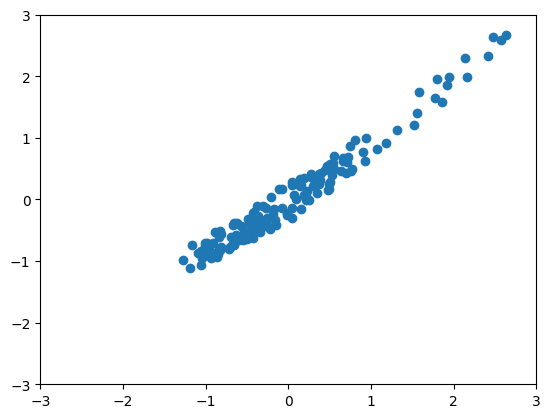

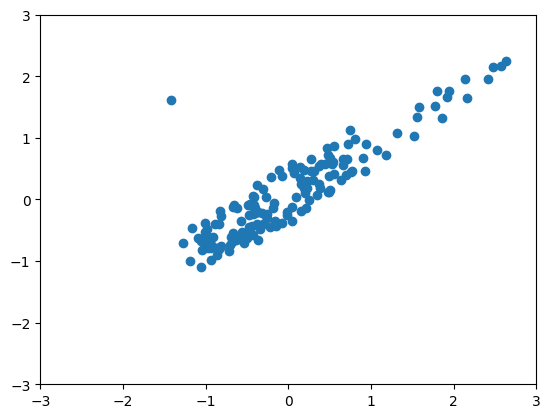

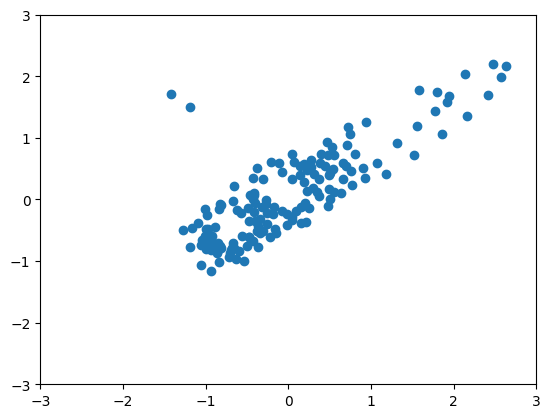

In [56]:
for i in range(0, n_pred):
    # how did we do!?
    plt.scatter(
        sc.inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1),
        sc.inverse_transform(oni_predictions[:, i].reshape(-1, 1)).reshape(-1)
        )
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.show()